In [1]:
import numpy as np
from online_cp import PluginMartingale, ConformalNearestNeighboursClassifier
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import h5py
from copy import deepcopy

rnd_gen = np.random.default_rng(2024)

plt.rcParams['svg.fonttype'] = 'none'
from matplotlib_inline.backend_inline import set_matplotlib_formats

# Set the desired output format
set_matplotlib_formats('svg')

from tol_colors import tol_cmap, tol_cset
cmap = tol_cset('bright')

SIZE = 1000000000 # Just for now

In [2]:
def plot_results(
        title,
        kenrel_martingale,
        beta_mom_martingale,
        beta_mle_martingale,
        beta_bayes_martingale,
        P_values=None,
        figsize=(12,4)
    ):
    if P_values:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axs[0].plot(np.log10(kenrel_martingale.martingale_values), label='kernel', color=cmap[0])
        axs[0].plot(np.log10(beta_mom_martingale.martingale_values), label='beta_moments', color=cmap[1])
        axs[0].plot(np.log10(beta_mle_martingale.martingale_values), label='beta_mle', color=cmap[2])
        axs[0].plot(np.log10(beta_bayes_martingale.martingale_values), label='beta_bayes', color=cmap[3])
        axs[0].legend()
        axs[0].set_ylabel(r'$\log_{10}M$')
        axs[0].grid()

        prange = np.linspace(0, 1, endpoint=True, num=1000)
        axs[1].plot(
            prange,
            [kenrel_martingale.current_betting_function(p) for p in prange], 
            label='kernel'
        )
        axs[1].plot(
            prange,
            [beta_mle_martingale.current_betting_function(p) for p in prange], 
            label='beta_mle'
        )
        axs[1].plot(
            prange,
            [beta_mom_martingale.current_betting_function(p) for p in prange], 
            label='beta_moments'
        )
        axs[1].plot(
            prange,
            [beta_bayes_martingale.current_betting_function(p) for p in prange], 
            label='beta_bayes'
        )
        axs[1].hist(P_values, bins=25, density=True, alpha=0.4)
        axs[1].legend()

        fig.suptitle(title)
        fig.tight_layout()

    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        ax.plot(np.log10(kenrel_martingale.martingale_values), label='kernel', color=cmap[0])
        ax.plot(np.log10(beta_mom_martingale.martingale_values), label='beta_moments', color=cmap[1])
        ax.plot(np.log10(beta_mle_martingale.martingale_values), label='beta_mle', color=cmap[2])
        ax.plot(np.log10(beta_bayes_martingale.martingale_values), label='beta_bayes', color=cmap[3])
        ax.legend()
        ax.set_ylabel(r'$\log_{10}M$')
        ax.grid()
        fig.suptitle(title)
        fig.tight_layout()

# USPS in original order

In [3]:
path = 'data_martingale_experiment/usps.h5'
with h5py.File(path, 'r') as hf:
    train = hf.get('train')
    X_train = train.get('data')[:]
    y_train = train.get('target')[:]
    test = hf.get('test')
    X_test = test.get('data')[:]
    y_test = test.get('target')[:]

X = np.concatenate([X_train, X_test])
Y = np.concatenate([y_train, y_test])

X = X[:SIZE]
Y = Y[:SIZE]

In [4]:
epsilon = 0.1
k = 1
cp = ConformalNearestNeighboursClassifier(k=k, label_space=np.unique(Y), rnd_state=2024, n_jobs=np.unique(Y).shape[0])

p_values_usps_orig = []

for i, (object, label) in tqdm(enumerate(zip(X, Y)), total=Y.shape[0], desc='Running online conformal prediction'):

    # Reality outputs object
    x = object

    # Forecaster outputs prediction set
    Gamma, p_values, D = cp.predict(x, epsilon=epsilon, return_p_values=True, return_update=True)
    
    # Reality outputs label
    y = label

    # Save the true p-value
    p_values_usps_orig.append(p_values[y])

    # Learn the label
    cp.learn_one(x, y, D)

print(cp.time_dict)
np.save('data_martingale_experiment/p_values_usps_orig', np.array(p_values_usps_orig))

Running online conformal prediction:   0%|          | 0/9298 [00:00<?, ?it/s]

{'Update distance matrix': 0.0774374008178711, 'Compute p-values': 8.92857813835144, 'Compute Gamma': 3.4809112548828125e-05}


In [5]:
P_values = deepcopy(p_values_usps_orig)

prior = 10
min_sample_size_mle = 20
min_sample_size_mom = 20

kenrel_martingale = PluginMartingale(betting_function='kernel', warnings=False)
beta_mle_martingale = PluginMartingale(betting_function='beta_mle', warnings=False, min_sample_size=min_sample_size_mle)
beta_mom_martingale = PluginMartingale(betting_function='beta_moments', warnings=False, min_sample_size=min_sample_size_mom)
beta_bayes_martingale = PluginMartingale(betting_function='beta_bayes', warnings=False, prior_alpha=prior, prior_beta=prior)

for p in tqdm(P_values, desc='Kernel'):
    kenrel_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='MOM'):
    beta_mom_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='MLE'):
    beta_mle_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='Bayes'):
    beta_bayes_martingale.update_log_martingale(p)

Kernel:   0%|          | 0/9298 [00:00<?, ?it/s]

MOM:   0%|          | 0/9298 [00:00<?, ?it/s]

MLE:   0%|          | 0/9298 [00:00<?, ?it/s]

Bayes:   0%|          | 0/9298 [00:00<?, ?it/s]

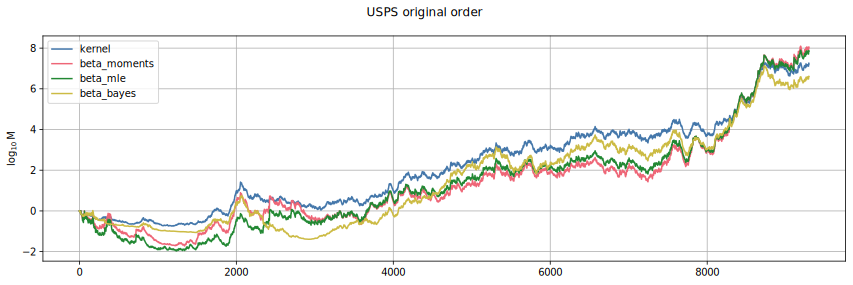

In [6]:
plot_results(
        'USPS original order',
        kenrel_martingale,
        beta_mom_martingale,
        beta_mle_martingale,
        beta_bayes_martingale,
        P_values=None,
        figsize=(12,4)
    )

# USPS random order

In [7]:
path = 'data_martingale_experiment/usps.h5'
with h5py.File(path, 'r') as hf:
    train = hf.get('train')
    X_train = train.get('data')[:]
    y_train = train.get('target')[:]
    test = hf.get('test')
    X_test = test.get('data')[:]
    y_test = test.get('target')[:]

X = np.concatenate([X_train, X_test])
Y = np.concatenate([y_train, y_test])

X = X[:SIZE]
Y = Y[:SIZE]

permutation = rnd_gen.permutation(len(X))
X = X[permutation]
Y = Y[permutation]

In [8]:
epsilon = 0.1
k = 1
cp = ConformalNearestNeighboursClassifier(k=k, label_space=np.unique(Y), rnd_state=2024, n_jobs=np.unique(Y).shape[0])

p_values_usps_shuffle = []

for i, (object, label) in tqdm(enumerate(zip(X, Y)), total=Y.shape[0], desc='Running online conformal prediction'):

    # Reality outputs object
    x = object

    # Forecaster outputs prediction set
    Gamma, p_values, D = cp.predict(x, epsilon=epsilon, return_p_values=True, return_update=True)
    
    # Reality outputs label
    y = label

    # Save the true p-value
    p_values_usps_shuffle.append(p_values[y])

    # Learn the label
    cp.learn_one(x, y, D)

print(cp.time_dict)
np.save('data_martingale_experiment/p_values_usps_shuffle', np.array(p_values_usps_shuffle))

Running online conformal prediction:   0%|          | 0/9298 [00:00<?, ?it/s]

{'Update distance matrix': 0.07930254936218262, 'Compute p-values': 9.102468490600586, 'Compute Gamma': 2.5033950805664062e-05}


In [9]:
P_values = deepcopy(p_values_usps_shuffle)

prior = 10
min_sample_size_mle = 20
min_sample_size_mom = 20

kenrel_martingale = PluginMartingale(betting_function='kernel', warnings=False)
beta_mle_martingale = PluginMartingale(betting_function='beta_mle', warnings=False, min_sample_size=min_sample_size_mle)
beta_mom_martingale = PluginMartingale(betting_function='beta_moments', warnings=False, min_sample_size=min_sample_size_mom)
beta_bayes_martingale = PluginMartingale(betting_function='beta_bayes', warnings=False, prior_alpha=prior, prior_beta=prior)

for p in tqdm(P_values, desc='Kernel'):
    kenrel_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='MOM'):
    beta_mom_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='MLE'):
    beta_mle_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='Bayes'):
    beta_bayes_martingale.update_log_martingale(p)

Kernel:   0%|          | 0/9298 [00:00<?, ?it/s]

MOM:   0%|          | 0/9298 [00:00<?, ?it/s]

MLE:   0%|          | 0/9298 [00:00<?, ?it/s]

Bayes:   0%|          | 0/9298 [00:00<?, ?it/s]

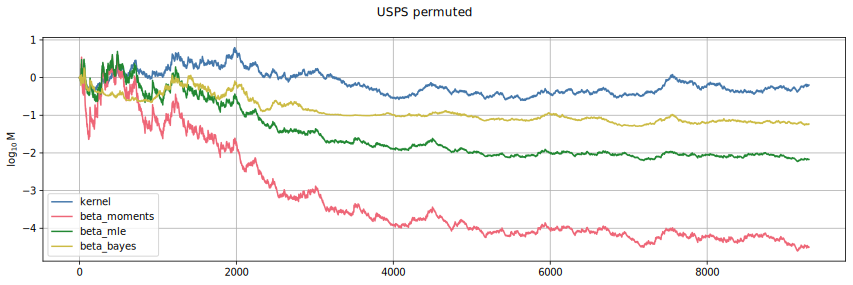

In [10]:
plot_results(
        'USPS permuted',
        kenrel_martingale,
        beta_mom_martingale,
        beta_mle_martingale,
        beta_bayes_martingale,
        P_values=None,
        figsize=(12,4)
    )

# Satelite in original order

In [11]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_landsat_satellite = fetch_ucirepo(id=146) 
  
# data (as pandas dataframes) 
X = statlog_landsat_satellite.data.features.values
Y = statlog_landsat_satellite.data.targets.values.flatten()

X = X[:SIZE]
Y = Y[:SIZE]

In [12]:
epsilon = 0.1
k = 1
cp = ConformalNearestNeighboursClassifier(k=k, label_space=np.unique(Y), rnd_state=2024, n_jobs=np.unique(Y).shape[0])

p_values_satelite_orig = [] # TODO: Give unique names to the p-values produced in each case, and save the arrays

for i, (object, label) in tqdm(enumerate(zip(X, Y)), total=Y.shape[0], desc='Running online conformal prediction'):

    # Reality outputs object
    x = object

    # Forecaster outputs prediction set
    Gamma, p_values, D = cp.predict(x, epsilon=epsilon, return_p_values=True, return_update=True)

    # Reality outputs label

    y = label
    # Save the true p-value
    p_values_satelite_orig.append(p_values[y])

    # Learn the label
    cp.learn_one(x, y, D)

print(cp.time_dict)
np.save('data_martingale_experiment/p_values_satelite_orig', np.array(p_values_satelite_orig))

Running online conformal prediction:   0%|          | 0/6435 [00:00<?, ?it/s]

{'Update distance matrix': 0.04053831100463867, 'Compute p-values': 3.05772066116333, 'Compute Gamma': 2.6702880859375e-05}


In [13]:
P_values = deepcopy(p_values_satelite_orig) # np.load('data_martingale_experiment/p_values_satelite_orig.npy')#

prior = 10
min_sample_size_mle = 20
min_sample_size_mom = 20

kenrel_martingale = PluginMartingale(betting_function='kernel', warnings=False)
beta_mle_martingale = PluginMartingale(betting_function='beta_mle', warnings=False, min_sample_size=min_sample_size_mle)
beta_mom_martingale = PluginMartingale(betting_function='beta_moments', warnings=False, min_sample_size=min_sample_size_mom)
beta_bayes_martingale = PluginMartingale(betting_function='beta_bayes', warnings=False, prior_alpha=prior, prior_beta=prior)

for p in tqdm(P_values, desc='Kernel'):
    kenrel_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='MOM'):
    beta_mom_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='MLE'):
    beta_mle_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='Bayes'):
    beta_bayes_martingale.update_log_martingale(p)

Kernel:   0%|          | 0/6435 [00:00<?, ?it/s]

MOM:   0%|          | 0/6435 [00:00<?, ?it/s]

MLE:   0%|          | 0/6435 [00:00<?, ?it/s]

Bayes:   0%|          | 0/6435 [00:00<?, ?it/s]

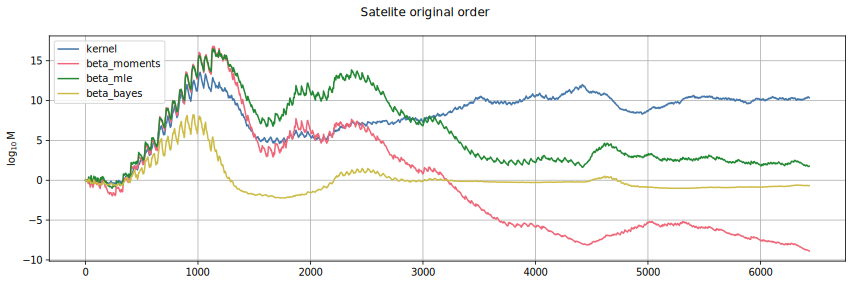

In [14]:
plot_results(
        'Satelite original order',
        kenrel_martingale,
        beta_mom_martingale,
        beta_mle_martingale,
        beta_bayes_martingale,
        P_values=None,
        figsize=(12,4)
    )

# Satelite permuted

In [15]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_landsat_satellite = fetch_ucirepo(id=146) 
  
# data (as pandas dataframes) 
X = statlog_landsat_satellite.data.features.values
Y = statlog_landsat_satellite.data.targets.values.flatten()

X = X[:SIZE]
Y = Y[:SIZE]

permutation = rnd_gen.permutation(len(X))
X = X[permutation]
Y = Y[permutation]

In [16]:
epsilon = 0.1
k = 1
cp = ConformalNearestNeighboursClassifier(k=k, label_space=np.unique(Y), rnd_state=2024, n_jobs=np.unique(Y).shape[0])

p_values_satelite_shuffle = [] # TODO: Give unique names to the p-values produced in each case, and save the arrays

for i, (object, label) in tqdm(enumerate(zip(X, Y)), total=Y.shape[0], desc='Running online conformal prediction'):

    # Reality outputs object
    x = object

    # Forecaster outputs prediction set
    Gamma, p_values, D = cp.predict(x, epsilon=epsilon, return_p_values=True, return_update=True)

    # Reality outputs label

    y = label
    # Save the true p-value
    p_values_satelite_shuffle.append(p_values[y])

    # Learn the label
    cp.learn_one(x, y, D)

print(cp.time_dict)
np.save('data_martingale_experiment/p_values_satelite_shuffle', np.array(p_values_satelite_shuffle))

Running online conformal prediction:   0%|          | 0/6435 [00:00<?, ?it/s]

{'Update distance matrix': 0.033853769302368164, 'Compute p-values': 3.2293643951416016, 'Compute Gamma': 2.7179718017578125e-05}


In [17]:
P_values = deepcopy(p_values_satelite_shuffle)

prior = 10
min_sample_size_mle = 20
min_sample_size_mom = 20

kenrel_martingale = PluginMartingale(betting_function='kernel', warnings=False)
beta_mle_martingale = PluginMartingale(betting_function='beta_mle', warnings=False, min_sample_size=min_sample_size_mle)
beta_mom_martingale = PluginMartingale(betting_function='beta_moments', warnings=False, min_sample_size=min_sample_size_mom)
beta_bayes_martingale = PluginMartingale(betting_function='beta_bayes', warnings=False, prior_alpha=prior, prior_beta=prior)

for p in tqdm(P_values, desc='Kernel'):
    kenrel_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='MOM'):
    beta_mom_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='MLE'):
    beta_mle_martingale.update_log_martingale(p)
for p in tqdm(P_values, desc='Bayes'):
    beta_bayes_martingale.update_log_martingale(p)

Kernel:   0%|          | 0/6435 [00:00<?, ?it/s]

MOM:   0%|          | 0/6435 [00:00<?, ?it/s]

MLE:   0%|          | 0/6435 [00:00<?, ?it/s]

Bayes:   0%|          | 0/6435 [00:00<?, ?it/s]

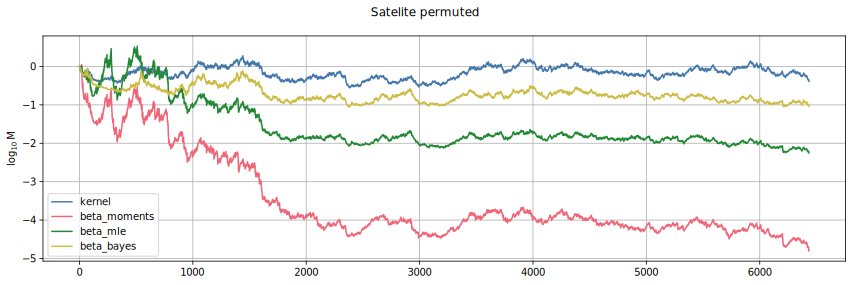

In [18]:
plot_results(
        'Satelite permuted',
        kenrel_martingale,
        beta_mom_martingale,
        beta_mle_martingale,
        beta_bayes_martingale,
        P_values=None,
        figsize=(12,4)
    )